# Goal

The purpose of this notebook is to 

> explore data sources, packages and ways to inform about trending topics within ESG.

The approach can then be generalized to other domains, such as data science, programing, food, ETFs or travel. 

The ideal data should have *search interest* for each keyword at time *t*. 


## pytrend

Inpsect `build_payload`

### Related Queries
 gprop: `['', 'images', 'news', 'youtube', 'froogle']`
 
### TODO 

get queries across geo and gprop
```
GEO = ['global', 'us', 'gb', 'au', 'in', 'ca']

GPROP = ['', 'news', 'youtube']
```

In [1]:
import pandas as pd
from pytrends.request import TrendReq
from datetime import datetime

# ~------------------ CONFIG ------------------~
SELECT_PROJECT = 'sustainable-finance-trends' # 'data-science-trends' # 
EXPORT_DATA    = True # store csv 

timestamp = datetime.now().strftime("%y%m%d_%H%M")
PROJECT = {
            'sustainable-finance-trends': {
                'file_name': f'../data/0_external/sustainable_finance_{timestamp}.csv',
                'kw_list': ['esg', 'sustainable finance',  'sustainable investment', 'responsible investment'], 
                'geo': 'global'
            },
           'data-science-trends': {
               'file_name': f'../data/0_external/data_science_{timestamp}.csv',
               'kw_list': ['data science', 'machine learning', 'deep learning', 'artificial intelligence', 'ai'], 
               'geo': 'global'
           },
}

print(f"Collect pytrend related searches for project:\t{SELECT_PROJECT}\n")
print(pd.DataFrame(PROJECT[SELECT_PROJECT].items()).explode(1).to_markdown())

# ~------------------ EXTRACT ------------------~
def get_queries(kw_list):
    """ Calls pytrend' related_queries with a list of keywords and geo settings 
    Input
        pytrend: TrendReq() session of pytrend
        kw_list: list of strings, used as input for query and passed to TrendReq().build_payload() 
    Return
        Dataframe with query result
    """    
    df_related_queries = pd.DataFrame()
    try:
        pytrend = TrendReq() 
        pytrend.build_payload(kw_list)
        df_related_queries = pytrend.related_queries()

        print(f"Query succeeded for", *kw_list, sep='\n\t')
    except Exception as e:
        print(e, "\nQuery not unsuccessful\n", '='*42)

    return df_related_queries

# ~------------------ TRANSFORM ------------------~
def process_queries(related_queries, kw, ranking, geo):
    try:
        df = related_queries[kw][ranking]
        df[['keyword', 'ranking', 'geo', 'query_timestamp']] = [kw, ranking, geo, datetime.now()]
    except:
        print(f"Append empty dataframe for {ranking}: {kw}")
        return pd.DataFrame(columns=['query', 'value', 'keyword', 'ranking', 'geo', 'query_timestamp'])
    
    return df

def create_df_related_queries(df_related_queries, geo='global'):
    """ Build the dataframe for all keywords
        Flatten Json format with nested lists to DataFrame
    """
    try: 
        df = pd.concat(
            [process_queries(
                df_related_queries, kw, ranking=r, geo=geo
            ) for r in [*df_related_queries[
                            [*df_related_queries][0]]
                       ] for kw in [*df_related_queries]])
    except:
        print("Google Trends returned nothing when calling related_queries(). Restart kernel and retry.")
        
    return df

# ~------------------ LOAD ------------------~
def write_to_csv(df, filename):
    print('_'*42, f'\nExport data, dimension: {df.shape} to\t{filename}\n')
    print(df.head().to_markdown())
    df.to_csv(f'{filename}', index=False) 

dict_related_queries = get_queries(kw_list=PROJECT[SELECT_PROJECT]['kw_list'])
df = create_df_related_queries(dict_related_queries)


if EXPORT_DATA:
    write_to_csv(df, filename=PROJECT[SELECT_PROJECT]['file_name'])

Collect pytrend related searches for project:	sustainable-finance-trends

|    | 0         | 1                                                      |
|---:|:----------|:-------------------------------------------------------|
|  0 | file_name | ../data/0_external/sustainable_finance_210228_0929.csv |
|  1 | kw_list   | esg                                                    |
|  1 | kw_list   | sustainable finance                                    |
|  1 | kw_list   | sustainable investment                                 |
|  1 | kw_list   | responsible investment                                 |
|  2 | geo       | global                                                 |
Query succeeded for
	esg
	sustainable finance
	sustainable investment
	responsible investment
__________________________________________ 
Export data, dimension: (151, 6) to	../data/0_external/sustainable_finance_210228_0929.csv

|    | query         |   value | keyword   | ranking   | geo    | query_timestamp       

---

## Trends data

TODO: links to google with texttemplate

### List files
### Plot

### Export to chart studio

In [3]:
from glob import glob
for i, f in enumerate(glob('../data/0_external/*.csv')):
    print(i,f)

0 ../data/0_external\data_science_210220_1241.csv
1 ../data/0_external\related_queries_210213_1046.csv
2 ../data/0_external\related_queries_210214_1014.csv
3 ../data/0_external\related_queries_210214_1435.csv
4 ../data/0_external\related_queries_210215_2133.csv
5 ../data/0_external\related_queries_210218_2021.csv
6 ../data/0_external\related_queries_210220_1029.csv
7 ../data/0_external\sustainable_finance_210223_2048.csv
8 ../data/0_external\sustainable_finance_210227_2137.csv
9 ../data/0_external\sustainable_finance_210228.csv
10 ../data/0_external\sustainable_finance_210228_0929.csv


In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import chart_studio.plotly as py

# ~------------------ SELECT INPUT DATA ------------------~
DATA_LOC = '../data/0_external\sustainable_finance_210228_0929.csv'
df_raw = pd.read_csv(DATA_LOC)
df = df_raw.copy()

## feature engineering: totals and normalize
grouped = df.groupby(['ranking']).value # group values by ranking
df['value_total'] = grouped.transform('sum') # total sum 
df['value_normalized'] = (df.value-grouped.transform('min'))/(grouped.transform('max')-grouped.transform('min')) # normalize 
df['value_normalized_total'] = df.groupby(['ranking']).value_normalized.transform('sum') # total sum of normalized values 
df['date'] = pd.to_datetime(df.query_timestamp).dt.strftime("%d. %B %Y")

# restrict on 5 hightest
# df = df.loc[df.groupby(["ranking", "keyword"]).value_normalized.nlargest(5).reset_index().level_2,:] 

## labels
df['labels'] = df['query'].apply(lambda x: x.replace(' ', '<br>')) # linebreaks
df['ranking_label'] = df.ranking.replace({'top': f'Evergreens - updated {df.date[0]}',
                                          'rising': f'Trending - updated {df.date[0]}'})


# link labels
def create_href(x, link_html="<a style='color:#9BCAB8; cursor:pointer' target='_blank' href='http://www.google.com/search?q={}'>{}</a>"): # #<a href='http://www.google.com/search?q={} '> {}</a>
    return link_html.format(x['query_insert_href'], x['labels'])

df['query_insert_href'] = df['query'].str.replace(" ", '+')
df['labels_href'] = df.apply(create_href, axis=1)

## top and rising
dfr, dft = df.query('ranking == "rising"'),  df.query('ranking == "top"')

In [15]:
df.date[0]

'28. February 2021'

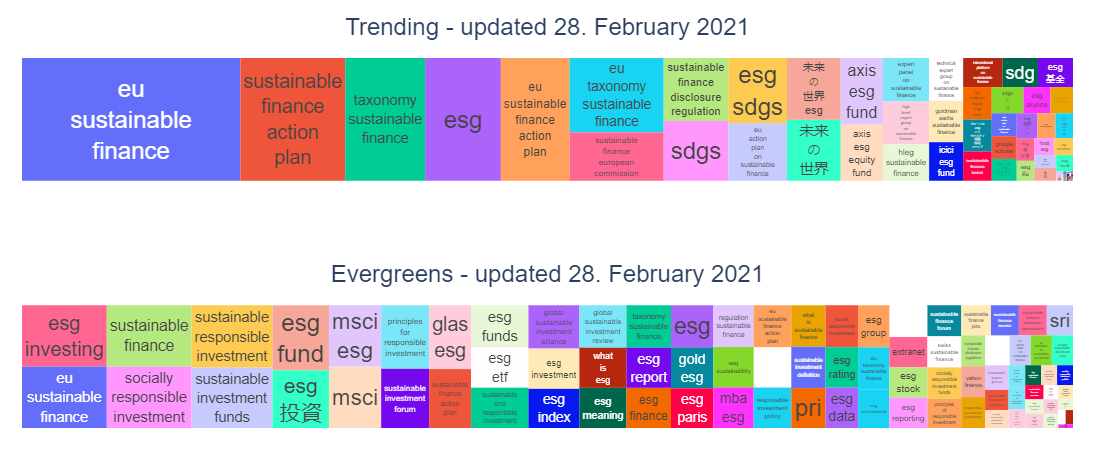

'https://plotly.com/~philippschmalen/17/'

In [13]:
fig = make_subplots(2, 1,
                    specs=[[{"type": "domain"}], [ {"type": "domain"}]])

fig.add_trace(go.Treemap(
    labels = dfr['labels'], #_href
    parents = dfr.ranking_label, 
    values = dfr.value_normalized, 
), 1, 1)

fig.add_trace(go.Treemap(
    labels = dft['labels'],
    parents = dft.ranking_label, 
    values = dft.value_normalized
), 2, 1)

fig.update_layout(margin=dict(t=10, b=10, r=10, l=10), 
#                   width=1200,
#                   height=900, 
                  plot_bgcolor= "rgba(0, 0, 0, 0)",
                  paper_bgcolor= "rgba(0, 0, 0, 0)",
#                  title_text=f'Updated: {df.date[0]}', 
#                  title_font_size=14
                 )

fig.update_traces(
    opacity=1, 
    textposition='middle center', 
    textfont={'family':"Arial", 'size': 20}, 
    hoverinfo= "label", # "skip",
    tiling = {'squarifyratio': 1, 'pad': 0}, 
    textfont_size=24, 
    marker={
#         'colors': df.index,
        'depthfade': True,
        'cauto': True,
#         'colorscale': 'Greys'
    }
)

fig.show()

py.plot(fig, filename=SELECT_PROJECT)

In [8]:
SELECT_PROJECT

'sustainable-finance-trends'

---

## Dash

In [11]:
# %load ../output/dash/app.py
"""

This is an example of the app.py file for a dash app deployed on Heroku. 
It creates http://esg-trending-test.herokuapp.com/

Follow the steps on https://dash.plotly.com/deployment 
to delploy the app with Heroku.

Note: 
    Put your data into the same folder or subfolder where `app.py` lives.

    I used a conda virtual environment, but installed all required packages 
    with `pip install` instead of `conda install`. This ensures that the 
    requirements.txt is readable by the Heroku Dyno. 


Author: Philipp Schmalen
License: MIT

"""

import os
import pandas as pd

# plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# dash
import dash
import dash_core_components as dcc
import dash_html_components as html


#~ --------------- SETTINGS --------------- ~
DATA_DIR = './data/'                # <WHERE YOUR DATA LIVES>
FILENAME = 'related_queries_210218_2021.csv' # <NAME OF THE FILE>.csv
#~ ---------------------------------------- ~



#~ --------------- DATA PREPARATION --------------- ~
def load_data(data_dir, filename):
    df_raw = pd.read_csv(os.path.join(DATA_DIR, FILENAME))
    df = df_raw.copy()

    return df

def prepare_data(df):
    """ Feature engineering for Google trends 'related queries'
    
    Input
        df: dataframe
    Return
        dfr, dft: dataframes with rising search interest (r) and top search interest (t)  

    """
    # feature engineering: totals and normalize
    grouped = df.groupby(['ranking']).value # group values by ranking
    df['value_total'] = grouped.transform('sum') # total sum 
    df['value_normalized'] = (df.value-grouped.transform('min'))/(grouped.transform('max')-grouped.transform('min')) # normalize 
    df['value_normalized_total'] = df.groupby(['ranking']).value_normalized.transform('sum') # total sum of normalized values 
    
    # labelling
    df['labels'] = df['query'].apply(lambda x: x.replace(' ', '<br>'))
    df['ranking_label'] = df.ranking.replace({'top': 'Evergreens', 'rising': 'Trending'})
    
    # rankings: top (t) and rising (r)
    dfr, dft = df.query('ranking == "rising"'),  df.query('ranking == "top"')

    return dfr, dft

#~ --------------- PIPELINE --------------- ~
dfr, dft = (load_data(DATA_DIR, FILENAME)
                .pipe(prepare_data))

#~ --------------- PLOT --------------- ~
fig = make_subplots(2, 1,
                    specs=[[{"type": "domain"}], [ {"type": "domain"}]])

fig.add_trace(go.Treemap(
    labels = dfr['labels'],
    parents = dfr.ranking_label, 
    values = dfr.value_normalized, 
), 1, 1)

fig.add_trace(go.Treemap(
    
    labels = dft['labels'],
    parents = dft.ranking_label, 
    values = dft.value_normalized
), 2, 1)

fig.update_layout(margin=dict(t=10, b=10, r=10, l=10))

fig.update_traces(
    opacity=1, 
    textposition='middle center', 
    textfont={'family':"Arial", 'size': 18}, 
    hoverinfo= "label",
    tiling = {'squarifyratio': 1, 'pad': 0}, 
    marker = {'depthfade': False}
)


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']


app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
server = app.server

app.layout = html.Div(children=[
    html.H1(children='Trending topics in sustainable finance'),

    html.Div(children='''
        Know what people search
    '''),

    dcc.Graph(
        id='example-graph',
        figure=fig
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)


#### Defining the Layout of Your Dash Application

Next, you’ll define the layout property of your application. This property dictates the look of your app. In this case, you’ll use a heading with a description below it and two graphs. Here’s how you define it:

# Dump

## Pandas profiling

In [20]:
from pandas_profiling import ProfileReport

from glob import glob


df = pd.read_csv(glob('../data/0_external/*210213*.csv')[0])
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

profile

### Query overview

#### Other approach, refactored

In [84]:
# unpack nested dict {keyword: {ranking: {DataFrame}} }
final_df = pd.DataFrame()
for keyword, ranking in related_queries_dict.items():
    for ranking_name, df in ranking.items():
        print(keyword, '>>>',ranking_name, '>>> DataFrame',df.shape, df.columns.values)

        
#     print(key, value.keys())
#     df = value
#     df.loc[:,'Country'] = key
#     final_df = pd.concat([df, final_df], 0)
# final_df

esg >>> top >>> DataFrame (25, 2) ['query' 'value']
esg >>> rising >>> DataFrame (25, 2) ['query' 'value']
sustainable finance >>> top >>> DataFrame (24, 2) ['query' 'value']
sustainable finance >>> rising >>> DataFrame (21, 2) ['query' 'value']
sustainable investment >>> top >>> DataFrame (14, 2) ['query' 'value']
sustainable investment >>> rising >>> DataFrame (11, 2) ['query' 'value']


#### Keyword suggestions

In [34]:
suggestions_dict = pytrend.suggestions(keyword=kw_list[3])
pd.DataFrame(suggestions_dict)

In [35]:
print(pytrend.suggestions(keyword='sustainable investment'), '\n')
print(pytrend.suggestions(keyword='sustainable investment funds'), '\n')

[{'mid': '/m/03cz3m_', 'title': 'Principles for Responsible Investment', 'type': 'Topic'}] 

[{'mid': '/g/11c740t89k', 'title': 'Investment Fund for Developing Countries', 'type': 'Company'}] 



#### Interest by region

In [38]:
# Interest by Region
interest_by_region_df = pytrend.interest_by_region()
print(interest_by_region_df.head())

                esg  sustainable finance  sustainable investment
geoName                                                         
Afghanistan       0                    0                       0
Albania           0                    0                       0
Algeria         100                    0                       0
American Samoa    0                    0                       0
Andorra           0                    0                       0


In [62]:
interest_by_region_df['sustainable finance'].nlargest(10)

geoName
Luxembourg              20
Belgium                 18
Switzerland             15
Ireland                 14
Netherlands             13
New Zealand             13
Indonesia               12
United Arab Emirates    12
Philippines             10
Sweden                  10
Name: sustainable finance, dtype: int32

In [63]:
interest_by_region_df['sustainable investment'].nlargest(10)

geoName
United Arab Emirates    9
Philippines             8
Malaysia                7
Australia               6
Belgium                 5
Netherlands             5
United Kingdom          5
India                   4
South Africa            4
Switzerland             4
Name: sustainable investment, dtype: int32

In [37]:
# Interest Over Time
interest_over_time_df = pytrend.interest_over_time()
print(interest_over_time_df.head())

In [46]:
# Get Google Hot Trends data
trending_searches_df = pytrend.trending_searches()
print(trending_searches_df.head())

                             0
0               Britney Spears
1  Judas and the Black Messiah
2                Brayden Smith
3                        Cuomo
4              Lincoln Project


In [37]:
# Get Google Hot Trends data
today_searches_df = pytrend.today_searches()
print(today_searches_df.head())

#### Top charts

In [163]:
# Get Google Top Charts
m = pytrend.top_charts(2020, hl='en-US', tz=360, geo='GLOBAL')

In [164]:
top_charts_global

,title,exploreQuery
0,Coronavirus,
1,Election results,
2,Kobe Bryant,
3,Zoom,
4,IPL,
5,India vs New Zealand,
6,Coronavirus update,
7,Coronavirus symptoms,
8,Joe Biden,
9,Google Classroom,


In [48]:
top_charts_de = pytrend.top_charts(2020, hl='en-US', tz=360, geo='DE')

,title,exploreQuery
0,Coronavirus,
1,US Wahl,
2,Wetter morgen,
3,Wirecard,
4,Biontech Aktie,
5,Kobe Bryant,
6,iPhone 12,
7,Disney Plus,
8,PS5,
9,Joe Biden,


In [55]:
top_charts_gb = pytrend.top_charts(2020, geo='GB')

,title,exploreQuery
0,Coronavirus,
1,US election,
2,Caroline Flack,
3,Coronavirus symptoms,
4,Coronavirus update,
5,Premier League,
6,Boris Johnson,
7,Eat Out to Help Out,
8,Kobe Bryant,
9,Kim Jong-un,


In [166]:
top_charts_dk = pytrend.top_charts(2020, geo='DK')

In [167]:
top_charts_dk

,title,exploreQuery
0,Romkugler,
1,Kanelsnegle,
2,Støvsuger,
3,Film på Netflix,
4,Brownie,
5,Brød,
6,Brætspil,
7,Stofmundbind,
8,Ishus,
9,Robotplæneklipper,
